In [5]:
from dotenv import load_dotenv
import os

import pandas as pd
import numpy as np
import math
from itertools import cycle
import statistics

#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint, shapiro, uniform
#from scipy.stats import uniform as sp_randFloat
#from scipy.stats import randint as sp_randInt

import scikitplot as skplt
import sklearn as sk
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
from statsmodels.tools import eval_measures

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [6]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [7]:
#  Federal Reserve Economic Data Service
load_dotenv()

fred_api_key = os.getenv("fred_api_key")
fred = Fred(api_key=fred_api_key)

In [8]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_misery, time_split
from common.calc_metrics import model_results
from common.LinearRegDiagnostic import LinearRegDiagnostic

# Setup

## variables

In [9]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_test', train0_df['FEDFUNDS'], train0_df['ffef_tr'], train0_df.shape[0], 2  , None )
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS'], test0_df['ffef_tr'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('ffef_tr2_test', train0_df['FEDFUNDS'], train0_df['ffef_tr2'], train0_df.shape[0], 2  , model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS'], test0_df['ffef_tr2'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('Naive_test', train0_df['FEDFUNDS'], train0_df['FEDFUNDS-1'], train0_df.shape[0], 1  , model_stats_df )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS'], test0_df['FEDFUNDS-1'], test0_df.shape[0], 1  , model_stats_df )

model_stats_df.round(2)

# Load Data

In [10]:
taylor_df = load_taylor()
train_df, test_df = time_split(taylor_df)

t1_df: (1007, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
ff_cpi_df: (832, 2)
train_df:  (197, 25)
test_df:  (49, 25)


In [11]:
taylor_df['chair_name'].unique()

array(['Martin', 'Burns', 'Miller', 'Volcker', 'Greenspan', 'Bernanke',
       'Yellen', 'Powell'], dtype=object)

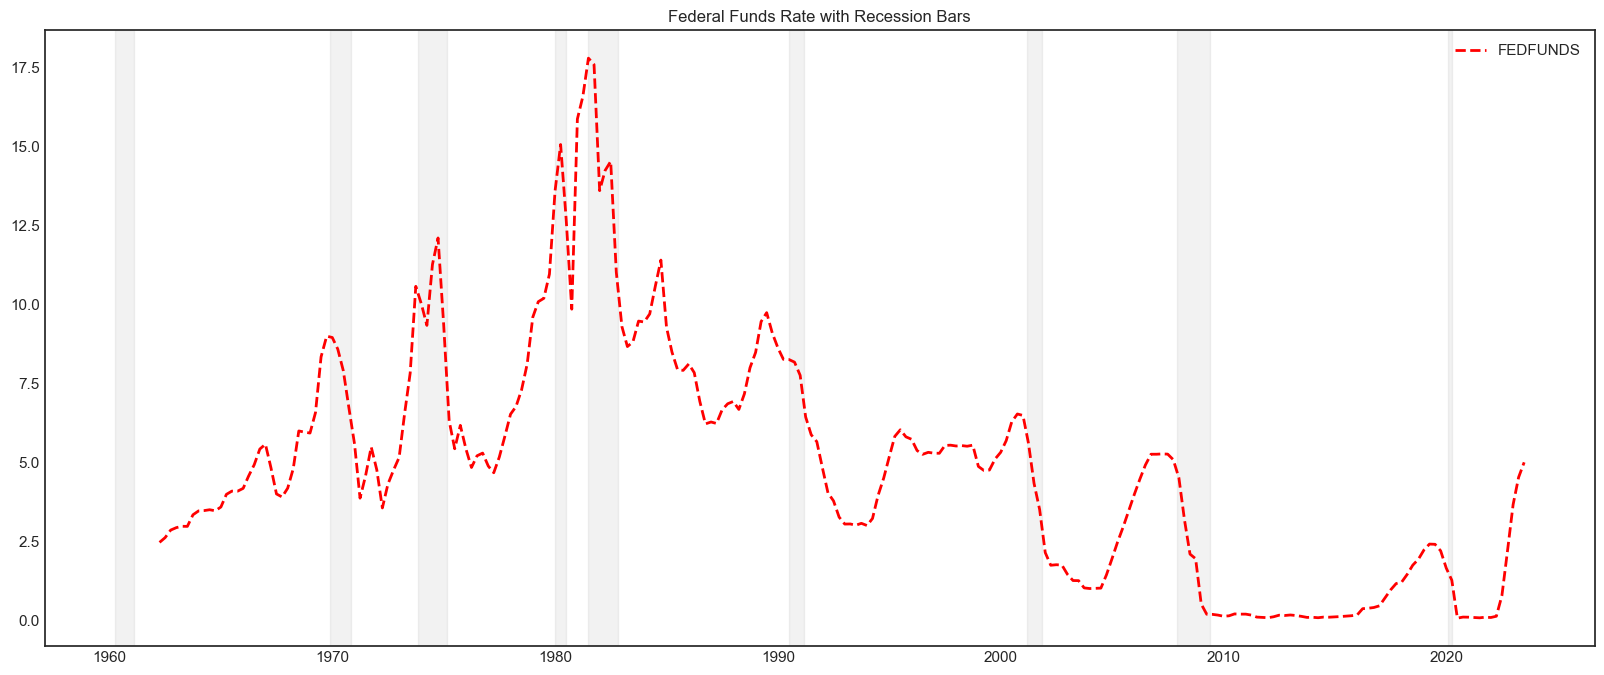

In [12]:
cycol = cycle('rgbcmyk')


t_df = taylor_df.query('DATE >= "1960-01-01"')
r_df = get_recession()
r_df = r_df.query('Peak_Date >= "1960-01-01"')

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)

# Plotting recession bars
for i,row in r_df.iterrows():
    plt.axvspan(row['Peak_Date'], row['Trough_Date'], color='gray', alpha=0.1)
   
ax.legend(["FEDFUNDS"])
ax.set(title='Federal Funds Rate with Recession Bars');
plt.show()

In [13]:
X_train = train_df[['FEDFUNDS-1','gap_inf', 'gap_ue', 'recession_flag']]
y_train = train_df['FEDFUNDS']


X_test = test_df[['FEDFUNDS-1','gap_inf', 'gap_ue', 'recession_flag']]
y_test = test_df['FEDFUNDS']

In [14]:
# Initialize Imputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

# Initialize Transformer / OneHotEncoder
cat_columns_lst = ['recession_flag']
num_columns_lst = ['FEDFUNDS-1','gap_inf', 'gap_ue']


ohe_categories = list()
for c in cat_columns_lst:
    ohe_categories.append(list(X_train[c].unique()))
    
ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                   sparse_output=False, handle_unknown='ignore')

transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')



numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
categorical_transformer = Pipeline( steps=[('transformer',transformer)])


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns_lst),
        ("cat", categorical_transformer, cat_columns_lst),
    ]
)

In [15]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
X_train_trf.columns = t_fit.get_feature_names_out()
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)

print('X_train_trf: ', X_train_trf.shape)

X_train_trf:  (197, 4)


In [16]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

print('X_test_trf: ', X_test_trf.shape)

X_test_trf:  (49, 4)


In [17]:
X_test_trf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49 entries, 2011-06-30 to 2023-06-30
Data columns (total 4 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   num__FEDFUNDS-1                          49 non-null     float64
 1   num__gap_inf                             49 non-null     float64
 2   num__gap_ue                              49 non-null     float64
 3   cat__onehotencoder__recession_flag_True  49 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB


# Stats Model - Taylor Index

In [18]:
X_train_const = sm.add_constant(X_train_trf)

In [19]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FEDFUNDS   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     699.3
Date:                Sun, 31 Dec 2023   Prob (F-statistic):          3.17e-113
Time:                        18:41:01   Log-Likelihood:                -251.43
No. Observations:                 197   AIC:                             512.9
Df Residuals:                     192   BIC:                             529.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.4068      0.137      2.972      0.003       0.137       0.677
num__FEDFUNDS-1                             0.9232      0.028     33.223      0.000       0.868       0.978
num__gap_inf                                0.1356      0.033      4.150      0.000       0.071       0.200
num__gap_ue                                -0.1302      0.040     -3.288      0.001      -0.208      -0.052
cat__onehotencoder__recession_flag_True    -0.9586      0.199     -4.826      0.000      -1.350      -0.567
==============================================================================
Omnibus:                       47.634   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              650.276
Skew:                           0.342   Prob(JB):                    6.23e-142
Kurtosis:                      11.874   Cond. No.                         24.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
train_pred = ols_result.predict(X_train_const)

t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)

In [21]:
#model_stats_df = model_results('ols_train', y_train, train_pred_ols['mean'], X_train.shape[0], X_train.shape[1], model_stats_df )

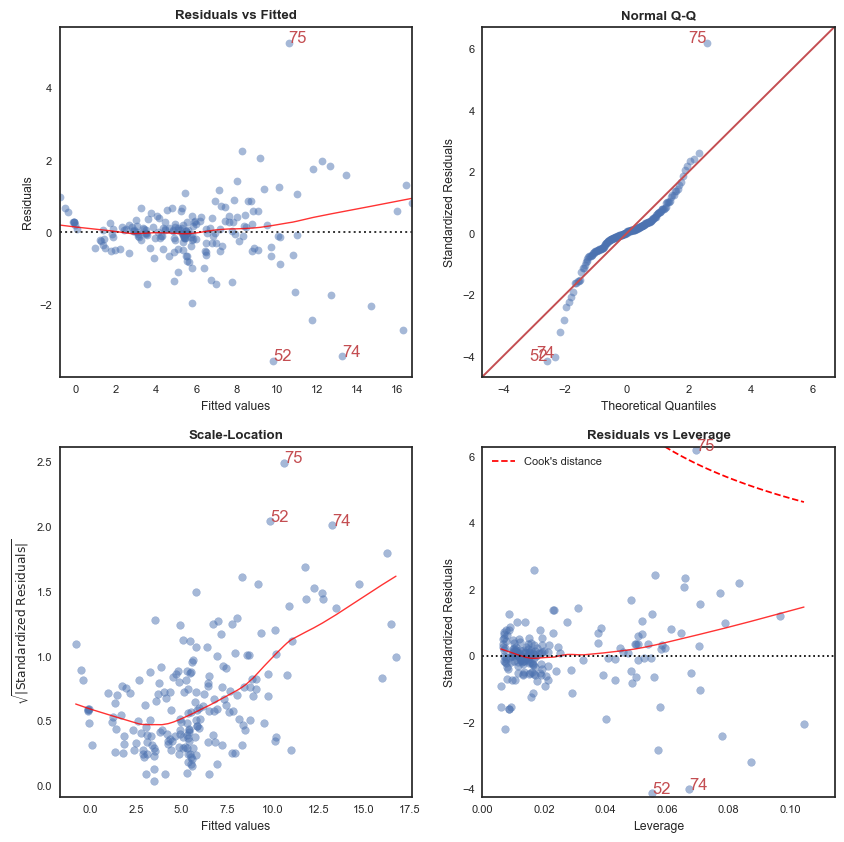

                                  Features  VIF Factor
0                                    const    4.785438
1                          num__FEDFUNDS-1    2.287508
2                             num__gap_inf    2.290665
3                              num__gap_ue    1.025710
4  cat__onehotencoder__recession_flag_True    1.191679


In [22]:
cls = LinearRegDiagnostic(ols_result)
vif, fig, ax = cls()
print(vif)

In [23]:
# Get the residuals from the fitted model
residuals = ols_result.resid

# Perform Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)

# Display the Shapiro-Wilk test statistic and p-value
print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", round(shapiro_test.pvalue,6))

Shapiro-Wilk Test Statistic: 0.8545700907707214
Shapiro-Wilk p-value: 0.0


## Test

In [24]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

X_test_const = sm.add_constant(X_test_trf)
print('X_test_const: ', X_test_const.shape)

X_test_const:  (49, 5)


In [25]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)
test_pred_ols.shape

(49, 6)

In [26]:
#model_stats_df = model_results('ols_test', y_test, test_pred_ols['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )

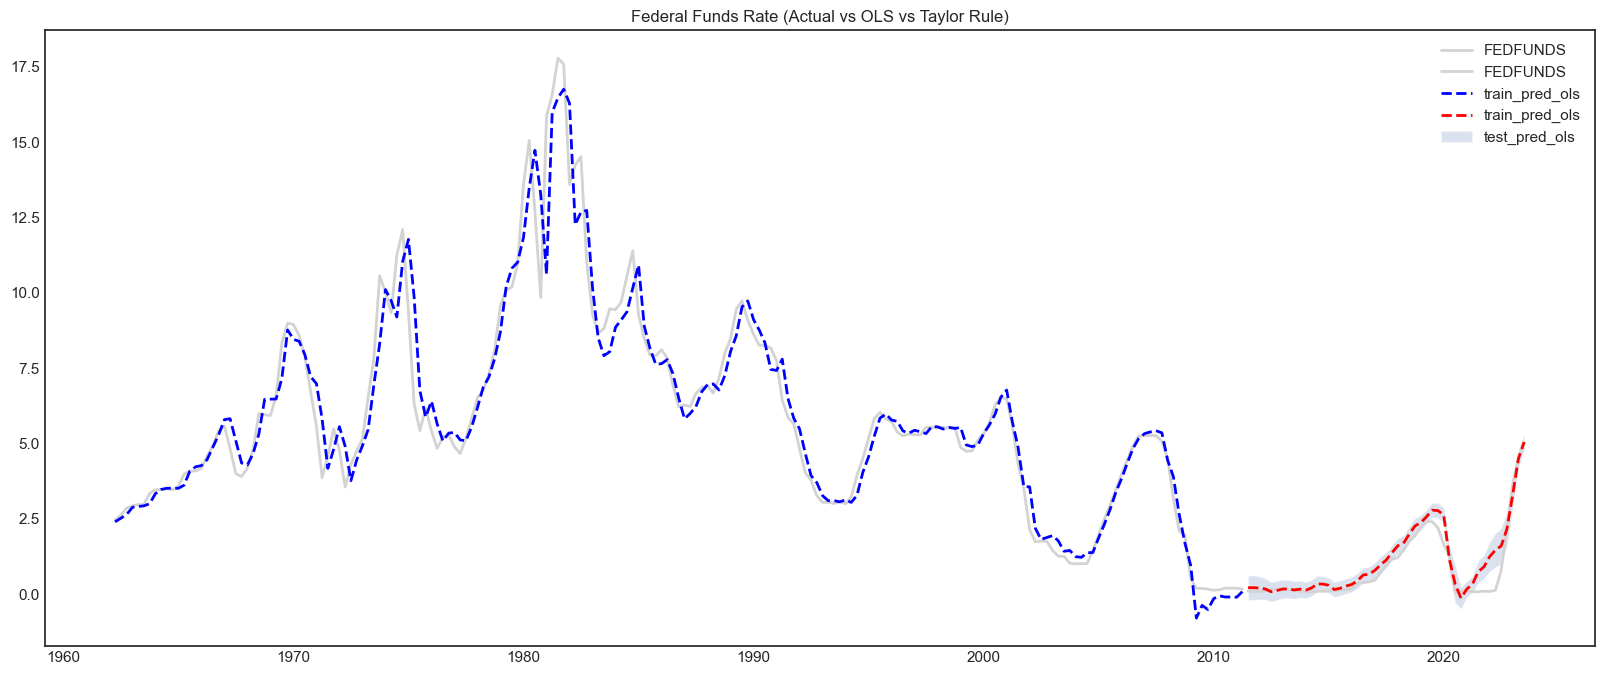

In [27]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_ols['mean'], color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_ols['mean'], color='red', linestyle='--', linewidth=2)
ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');
plt.show()

# Lasso

In [28]:
# Lasso with 5 fold cross-validation
lasso_cv_model = LassoCV(cv=5, random_state=rand_int, max_iter=10000)

# Fit model
lasso_cv_model.fit(X_train_trf, y_train)

print('model.alpha_: ', lasso_cv_model.alpha_)

model.alpha_:  0.01118420293975338


In [29]:
lasso_best = Lasso(alpha=lasso_cv_model.alpha_)
lasso_best.fit(X_train_trf, y_train)

train_pred_lasso = lasso_best.predict(X_train_trf)

In [30]:
feature_df = pd.DataFrame(lasso_best.coef_, t_fit.get_feature_names_out())
feature_df.columns = ['coef']
feature_df

,coef
num__FEDFUNDS-1,0.920216
num__gap_inf,0.131149
num__gap_ue,-0.124290
cat__onehotencoder__recession_flag_True,-0.839546


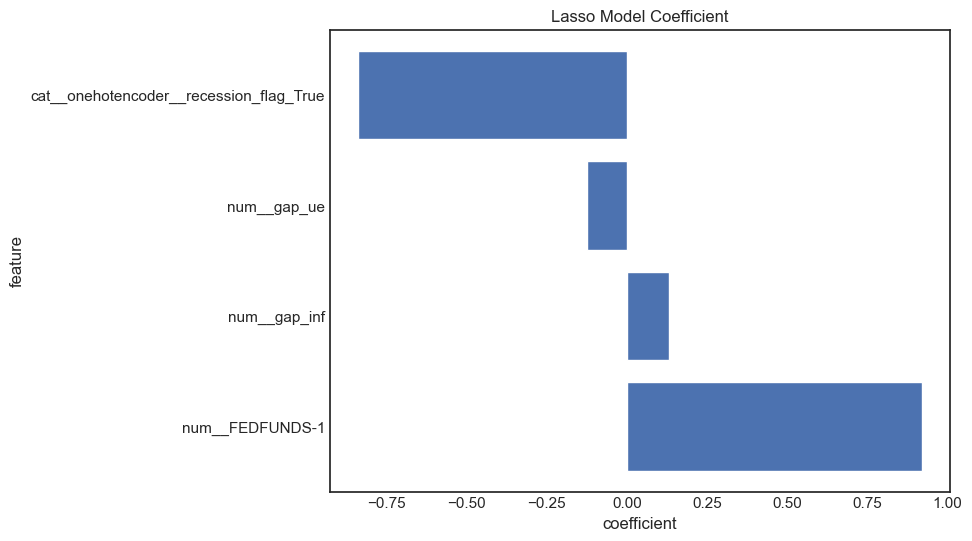

In [31]:
# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.barh(feature_df.index, feature_df['coef'])

#plt.legend()
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('Lasso Model Coefficient')
plt.grid(False)
plt.show()

In [32]:
#model_stats_df = model_results('lasso_train', y_train, train_pred_lasso, X_train.shape[0], X_train.shape[1] , model_stats_df )

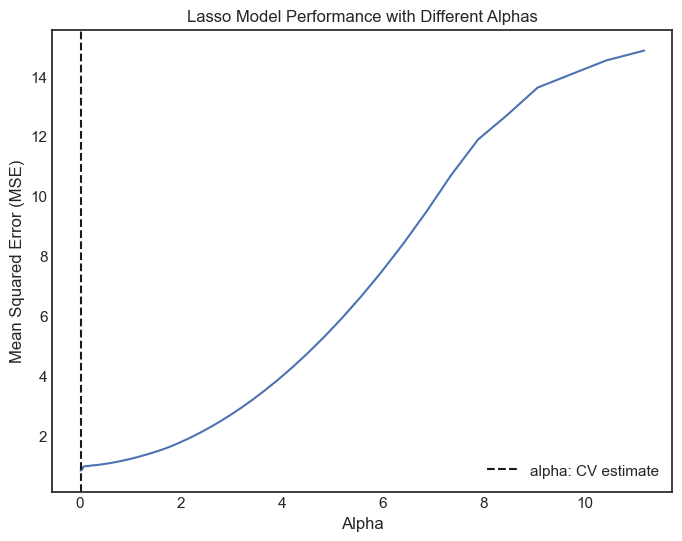

In [33]:
mse_values = np.mean(lasso_cv_model.mse_path_, axis=1)

# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.plot(lasso_cv_model.alphas_, mse_values)

plt.axvline(
    lasso_cv_model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lasso Model Performance with Different Alphas')
plt.grid(False)
plt.show()

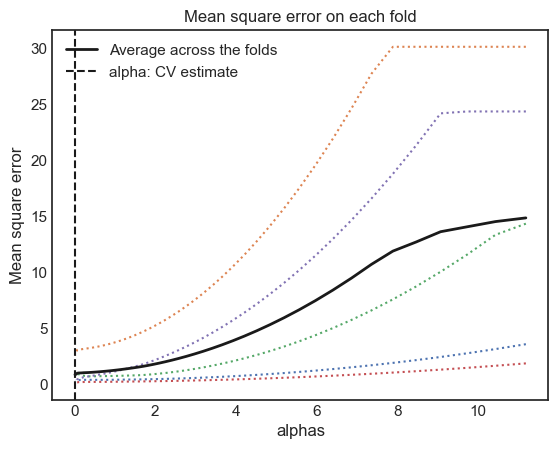

In [34]:
#plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(lasso_cv_model.alphas_, lasso_cv_model.mse_path_, ":")
plt.plot(
    lasso_cv_model.alphas_ ,
    lasso_cv_model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    lasso_cv_model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

plt.show()

#ymin, ymax = 50000, 250000
#plt.ylim(ymin, ymax);

In [35]:
test_pred_lasso = lasso_best.predict(X_test_trf)
print('test_pred_lasso: ', test_pred_lasso.shape)

test_pred_lasso:  (49,)


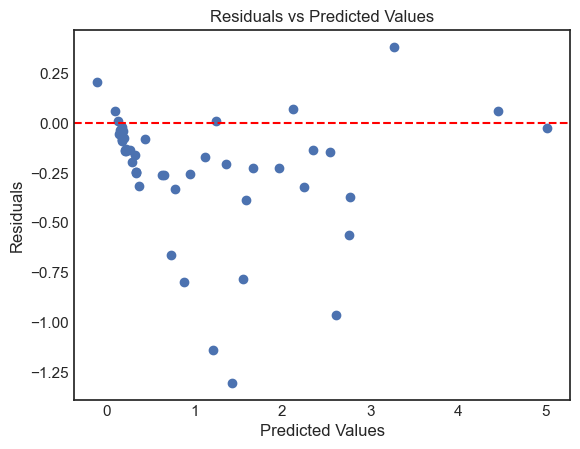

In [36]:
residuals = y_test - test_pred_lasso

plt.scatter(test_pred_lasso, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='red', linestyle='--')  # Add horizontal line at y=0 for reference
plt.show()

In [37]:
#model_stats_df = model_results('lasso_test', y_test, test_pred_lasso, X_test.shape[0], X_test.shape[1] , model_stats_df )

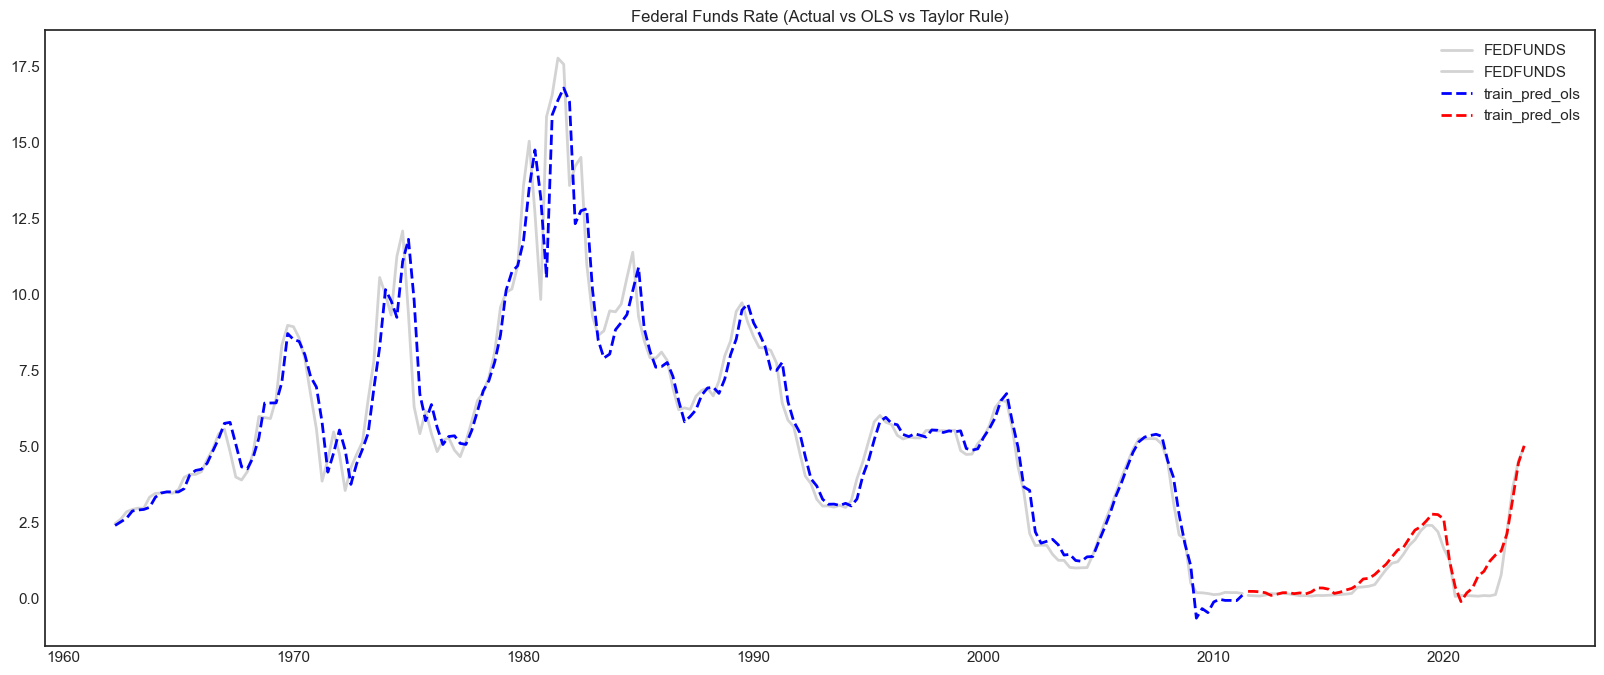

In [38]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_lasso, color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_lasso, color='red', linestyle='--', linewidth=2)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

plt.show()

# LGBM

In [39]:
pipe_ltb = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',ltb.LGBMRegressor())]
)

param_ltb = {
    'model__n_estimators': randint(100, 300), #[100, 200, 300],
    'model__learning_rate': uniform(0.01, 0.5),  #[0.01, 0.05, 0.1, 0.5],
    'model__max_depth': randint(3, 10),
    'model__num_leaves': randint(3, 60),
    'model__min_data_in_leaf' : randint(10, 20),
    'model__reg_alpha' : uniform(0.01, 0.1), 
    'model__verbose': [-1],
    'model__eval_metric': ['r2_score'],
}


cv = RandomizedSearchCV(estimator = pipe_ltb, 
                        param_distributions = param_ltb,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('LGBMR', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

LGBMR ) Best Accuracy Score: 0.5685820096071511 Parameters: {} {'model__eval_metric': 'r2_score', 'model__learning_rate': 0.07080190027136073, 'model__max_depth': 7, 'model__min_data_in_leaf': 10, 'model__n_estimators': 270, 'model__num_leaves': 9, 'model__reg_alpha': 0.050063162736167365, 'model__verbose': -1}


In [40]:
cv.best_estimator_.named_steps.model

LGBMRegressor(eval_metric='r2_score', learning_rate=0.07080190027136073,
              max_depth=7, min_data_in_leaf=10, n_estimators=270, num_leaves=9,
              reg_alpha=0.050063162736167365, verbose=-1)

In [41]:
train_pred_lgbm = cv.best_estimator_.predict(X_train, pred_contrib=False, raw_score=False)

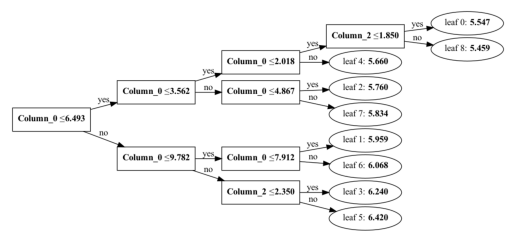

In [42]:
ltb.plot_tree(cv.best_estimator_.named_steps.model)
plt.show()

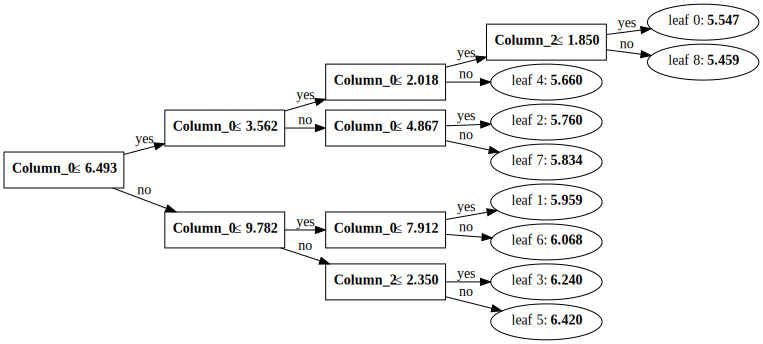

In [43]:
ltb.create_tree_digraph(cv.best_estimator_.named_steps.model)

In [44]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.feature_names_in_,
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})

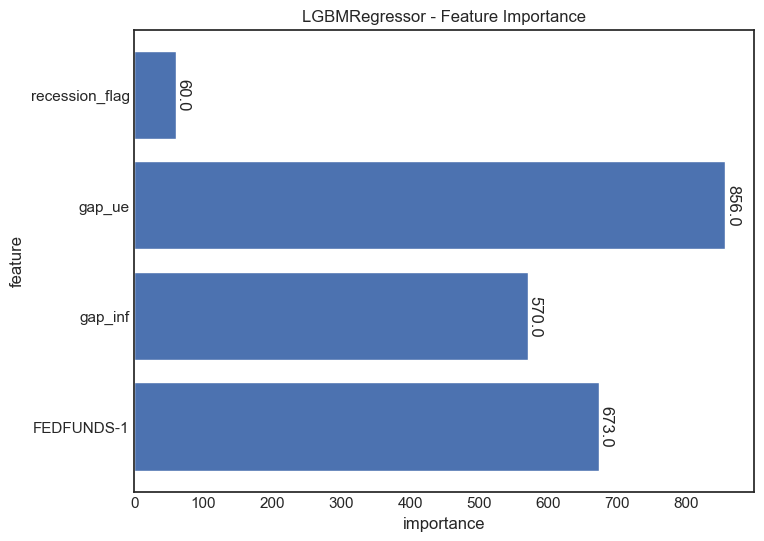

In [45]:
plt.figure(figsize=(8, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.1f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('LGBMRegressor - Feature Importance')
plt.grid(False)
plt.show()

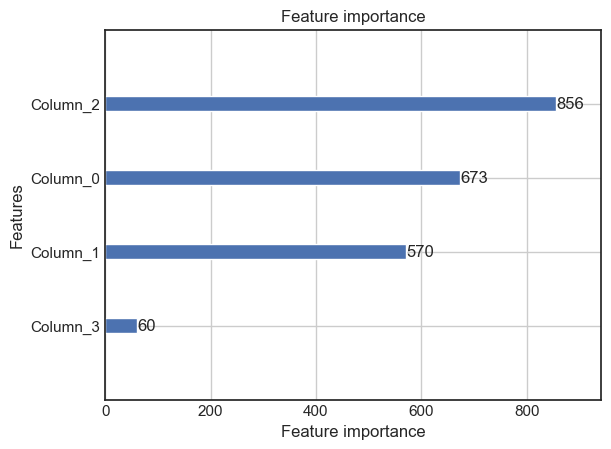

In [46]:
ltb.plot_importance(cv.best_estimator_.named_steps.model)
plt.show()

In [47]:
#model_stats_df = model_results('lgbm_train', y_train, train_pred_lgbm, X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [48]:
test_pred_lgbm = cv.best_estimator_.predict(X_test, pred_contrib=False, raw_score=False)
test_pred_lgbm.shape

(49,)

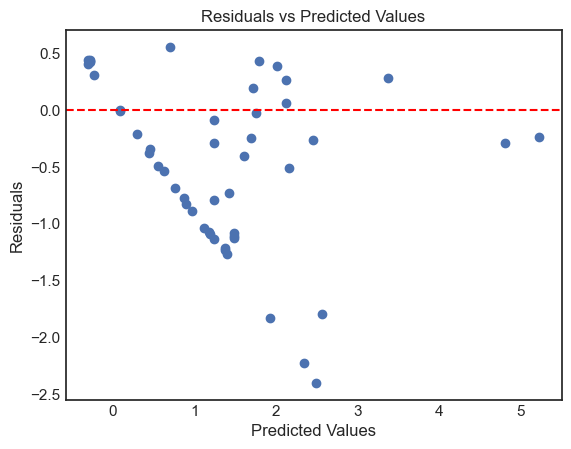

In [49]:
residuals = y_test - test_pred_lgbm
plt.scatter(test_pred_lgbm, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='red', linestyle='--')  # Add horizontal line at y=0 for reference
plt.show()

In [50]:
#model_stats_df = model_results('lgbm_test', y_test, test_pred_lgbm, X_test.shape[0], X_test.shape[1] , model_stats_df )

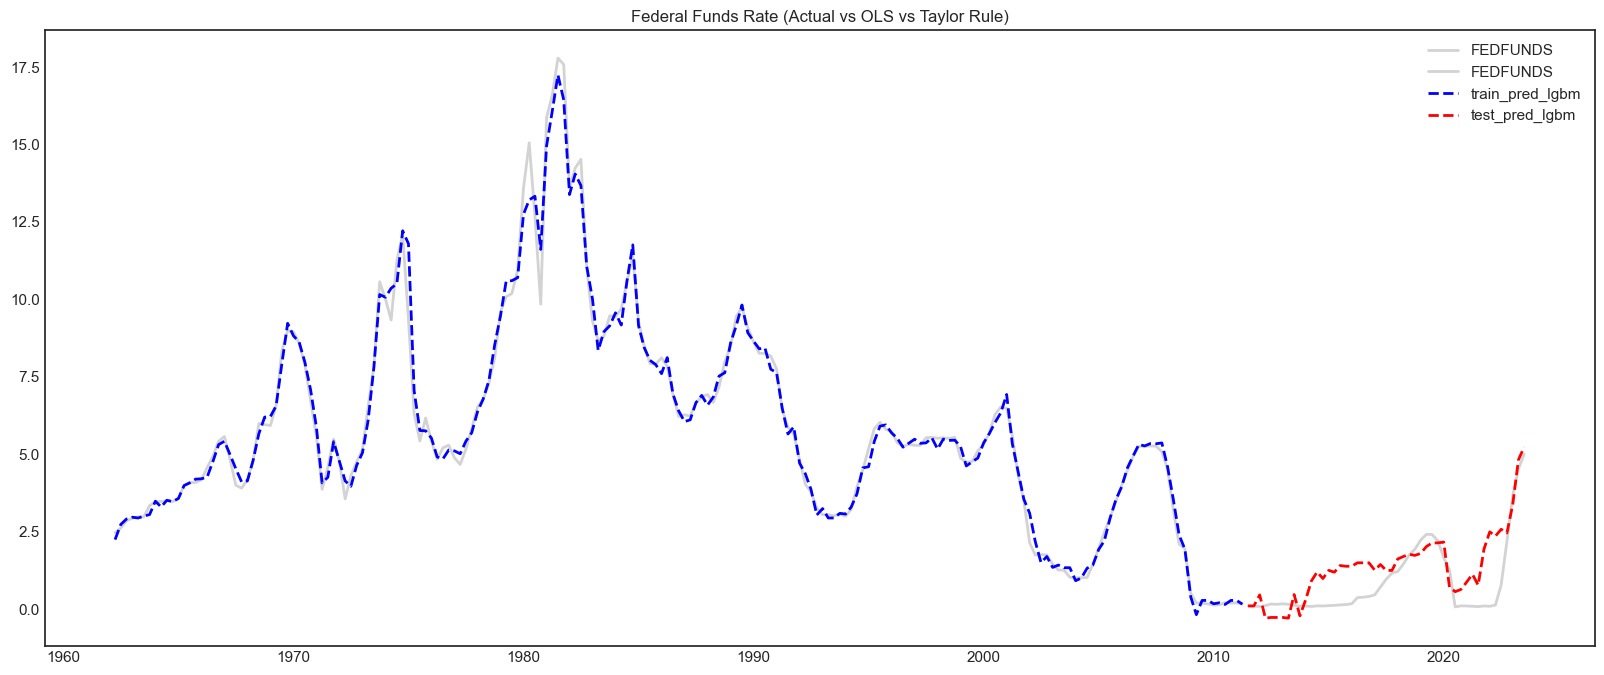

In [51]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lgbm, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_lgbm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');
plt.show()

# XGB

In [52]:
pipe_xgb = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',xgb.XGBRegressor())]
)

param_xgb = {
    'model__learning_rate': uniform(0.01, 0.5),
    'model__n_estimators': randint(100, 300),
    'model__max_depth': randint(3, 10),
    'model__min_child_weight' : randint(1, 15),
    'model__subsample' : uniform(0.05, 1.0),
    'model__colsample_bytree' : uniform(0.05, 1.0),
    'model__reg_alpha' : uniform(0.01, 0.1), 
    'model__verbose': [-1],
}


cv = RandomizedSearchCV(estimator = pipe_xgb, 
                        param_distributions = param_xgb,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('XGB', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

XGB ) Best Accuracy Score: 0.5348030597301847 Parameters: {} {'model__colsample_bytree': 0.7831259776126707, 'model__learning_rate': 0.36131117762762316, 'model__max_depth': 7, 'model__min_child_weight': 2, 'model__n_estimators': 144, 'model__reg_alpha': 0.10780580790165188, 'model__subsample': 0.6745821117353524, 'model__verbose': -1}


In [53]:
cv.best_estimator_.named_steps.model.score(X_train_trf, y_train)

0.9999516790586223

In [54]:
cv.best_estimator_.named_steps.model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7831259776126707, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.36131117762762316, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=144, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [55]:
train_pred_xgb = cv.best_estimator_.predict(X_train)

In [56]:
fig, ax = plt.subplots(figsize=(25,10))
#plt.figure(figsize=(12,12))
#xgb.plot_tree(xgb_model, ax=ax)
xgb.plot_tree(cv.best_estimator_.named_steps.model, ax=ax,fontsize=10)

fig.set_size_inches(150, 100)
fig.savefig('tree.png')

plt.show()

In [57]:
cv

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imp_num',
                                                                                                SimpleImputer())]),
                                                                               ['FEDFUNDS-1',
                                                                                'gap_inf',
                                                                                'gap_ue']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('transformer',
                                                                                                ColumnTransformer(transformers=[('onehotencoder',
                                                                                                                                 OneHotEncoder(categories=[[False,
                                                                                                                                                            True]],
                                                                                                                                               drop='first',
                                                                                                                                               handle_unknown='ignore',
                                                                                                                                               spars...
                                        'model__min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x28b867e20>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x28b867f10>,
                                        'model__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x28b8d0790>,
                                        'model__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x28b8d3100>,
                                        'model__verbose': [-1]},
                   random_state=12, scoring='r2')

In [58]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.feature_names_in_,
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})

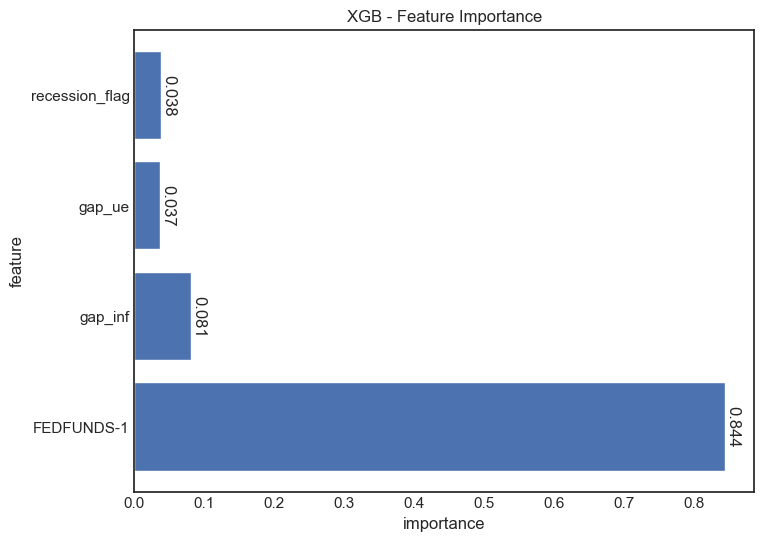

In [59]:
plt.figure(figsize=(8, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.3f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('XGB - Feature Importance')
plt.grid(False)
plt.show()

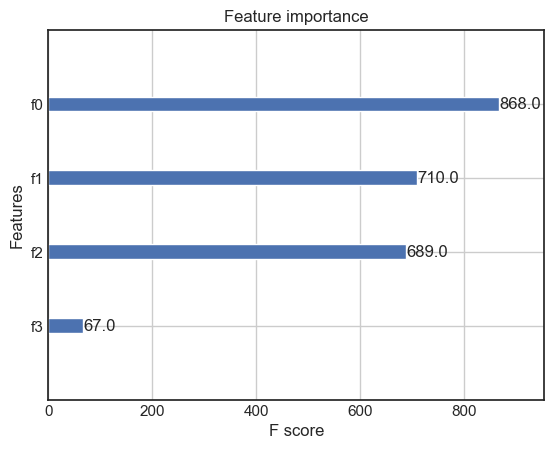

In [60]:
xgb.plot_importance(cv.best_estimator_.named_steps.model)
plt.show()

In [61]:
#model_stats_df = model_results('xgb_train', y_train, train_pred_xgb, X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [62]:
test_pred_xgb = cv.best_estimator_.predict(X_test)
print('test_pred_xbg: ', test_pred_xgb.shape)

test_pred_xbg:  (49,)


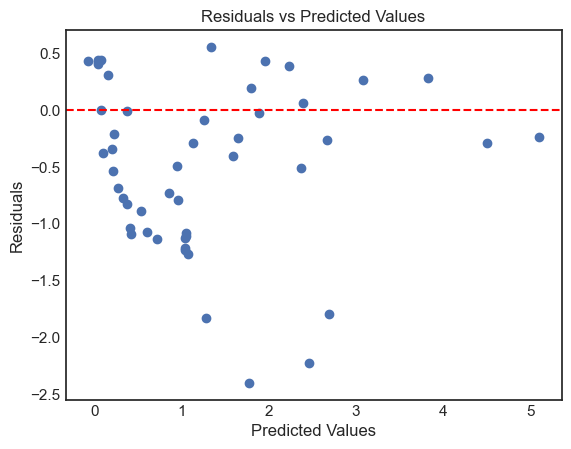

In [63]:
residuals = y_test - test_pred_lgbm
plt.scatter(test_pred_xgb, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='red', linestyle='--')  # Add horizontal line at y=0 for reference
plt.show()

In [64]:
#model_stats_df = model_results('xgb_test', y_test, test_pred_lgbm, X_test.shape[0], X_test.shape[1] , model_stats_df )

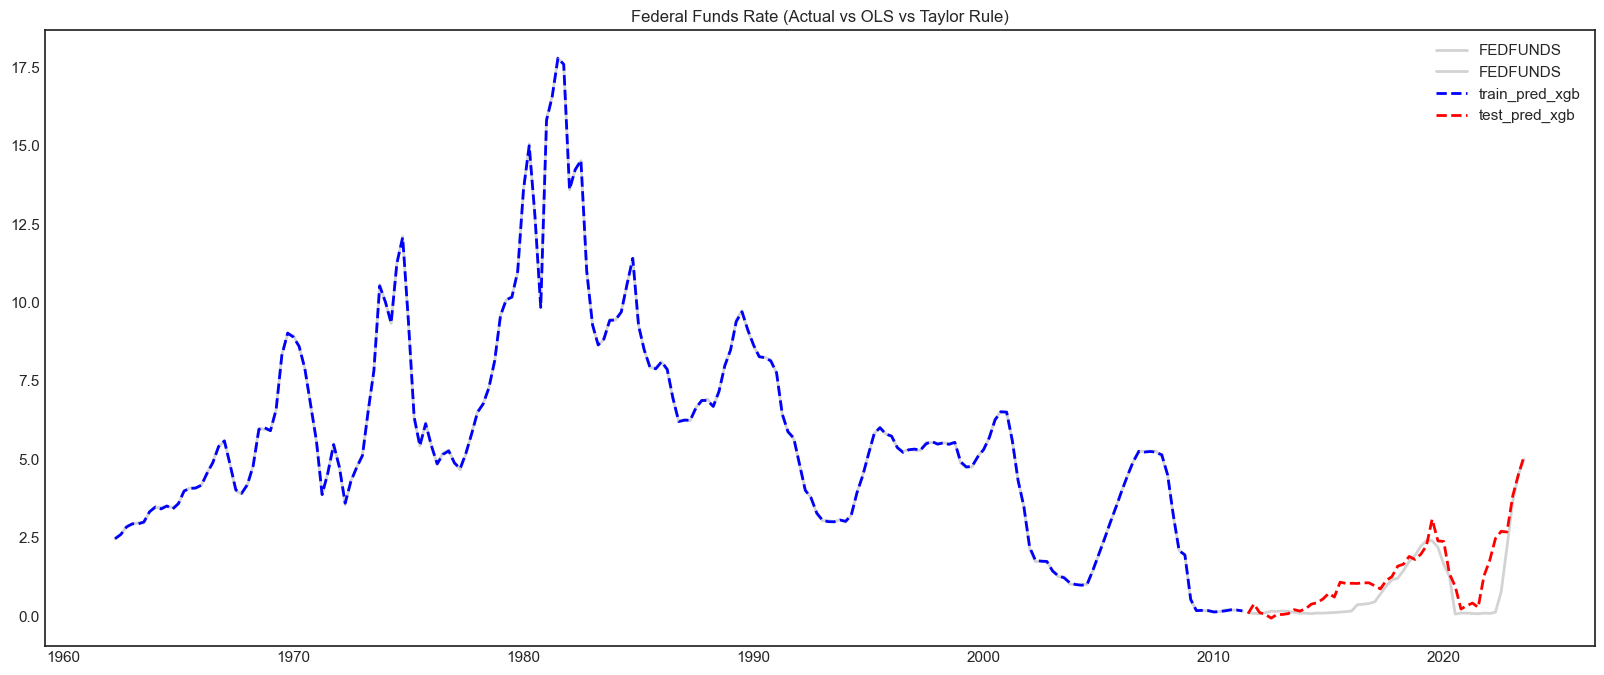

In [65]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_xgb, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_xgb, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_xgb","test_pred_xgb"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');
plt.show()

# AdaBoostRegressor

In [66]:
pipe_ada = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',AdaBoostRegressor())]
)

param_ada = {
    'model__learning_rate' : [0.01, 0.1, 0.5, 1.0],
    'model__n_estimators' : [50, 100, 150, 200, 250],
    'model__loss' : ["linear","exponential"],  
}


cv = RandomizedSearchCV(estimator = pipe_ada, 
                        param_distributions = param_ada,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('ADA', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

ADA ) Best Accuracy Score: 0.5726514174768236 Parameters: {} {'model__n_estimators': 250, 'model__loss': 'exponential', 'model__learning_rate': 0.01}


In [67]:
cv.best_estimator_.named_steps.model.score(X_train_trf, y_train)

0.9452892009796066

In [68]:
cv.best_estimator_.named_steps.model

AdaBoostRegressor(learning_rate=0.01, loss='exponential', n_estimators=250)

In [69]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.feature_names_in_,
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})

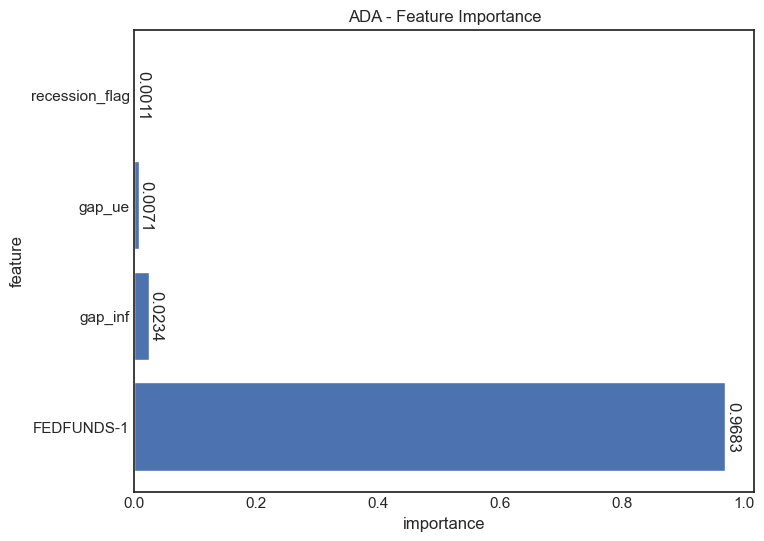

In [70]:
plt.figure(figsize=(8, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.4f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('ADA - Feature Importance')
plt.grid(False)
plt.show()

In [71]:
train_pred_ada = cv.best_estimator_.predict(X_train)
#model_stats_df = model_results('ada_test', y_train, train_pred_ada, X_train.shape[0], X_train.shape[1] , model_stats_df )

In [72]:
test_pred_ada = cv.best_estimator_.predict(X_test)
#model_stats_df = model_results('ada_test', y_test, test_pred_ada, X_test.shape[0], X_test.shape[1] , model_stats_df )

# tsa.SARIMAX

In [73]:
sarimax_model = sm.tsa.SARIMAX(y_train, exog=X_train_trf).fit(disp=False)

sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  197
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -254.412
Date:                Sun, 31 Dec 2023   AIC                            520.824
Time:                        18:41:21   BIC                            540.523
Sample:                    03-31-1962   HQIC                           528.798
                         - 03-31-2011                                         
Covariance Type:                  opg                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
num__FEDFUNDS-1                             0.9802      0.026     36.992      0.000       0.928       1.032
num__gap_inf                                0.1094      0.029      3.724      0.000       0.052       0.167
num__gap_ue                                -0.1057      0.063     -1.679      0.093      -0.229       0.018
cat__onehotencoder__recession_flag_True    -0.9419      0.201     -4.676      0.000      -1.337      -0.547
ar.L1                                       0.1252      0.061      2.069      0.039       0.007       0.244
sigma2                                      0.7748      0.041     19.096      0.000       0.695       0.854
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              1037.04
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
train_result = sarimax_model.get_prediction(start=-len(X_train_trf), dynamic=True)

In [75]:
train_pred_SARIM = train_result.summary_frame()
train_pred_SARIM

FEDFUNDS,mean,mean_se,mean_ci_lower,mean_ci_upper
1962-03-31,2.164482,0.887236,0.425531,3.903433
1962-06-30,2.275851,0.887236,0.536900,4.014802
1962-09-30,2.407821,0.887236,0.668871,4.146772
1962-12-31,2.657358,0.887236,0.918407,4.396309
1963-03-31,2.700044,0.887236,0.961093,4.438994
...,...,...,...,...
2010-03-31,-0.354554,0.887236,-2.093504,1.384397
2010-06-30,-0.383307,0.887236,-2.122258,1.355644
2010-09-30,-0.369691,0.887236,-2.108641,1.369260
2010-12-31,-0.376840,0.887236,-2.115790,1.362111


## Test

In [76]:
s_idx = len(X_train_trf)
e_idx = s_idx + len(X_test_trf) - 1

test_result = sarimax_model.get_prediction(start=s_idx, end=e_idx, exog=X_test_trf, dynamic=True)

In [77]:
test_pred_SARIM = test_result.summary_frame()
test_pred_SARIM.shape

predict_ci = test_result.conf_int(alpha=0.5)
print('predict_ci: ',predict_ci.shape)

predict_ci:  (49, 2)


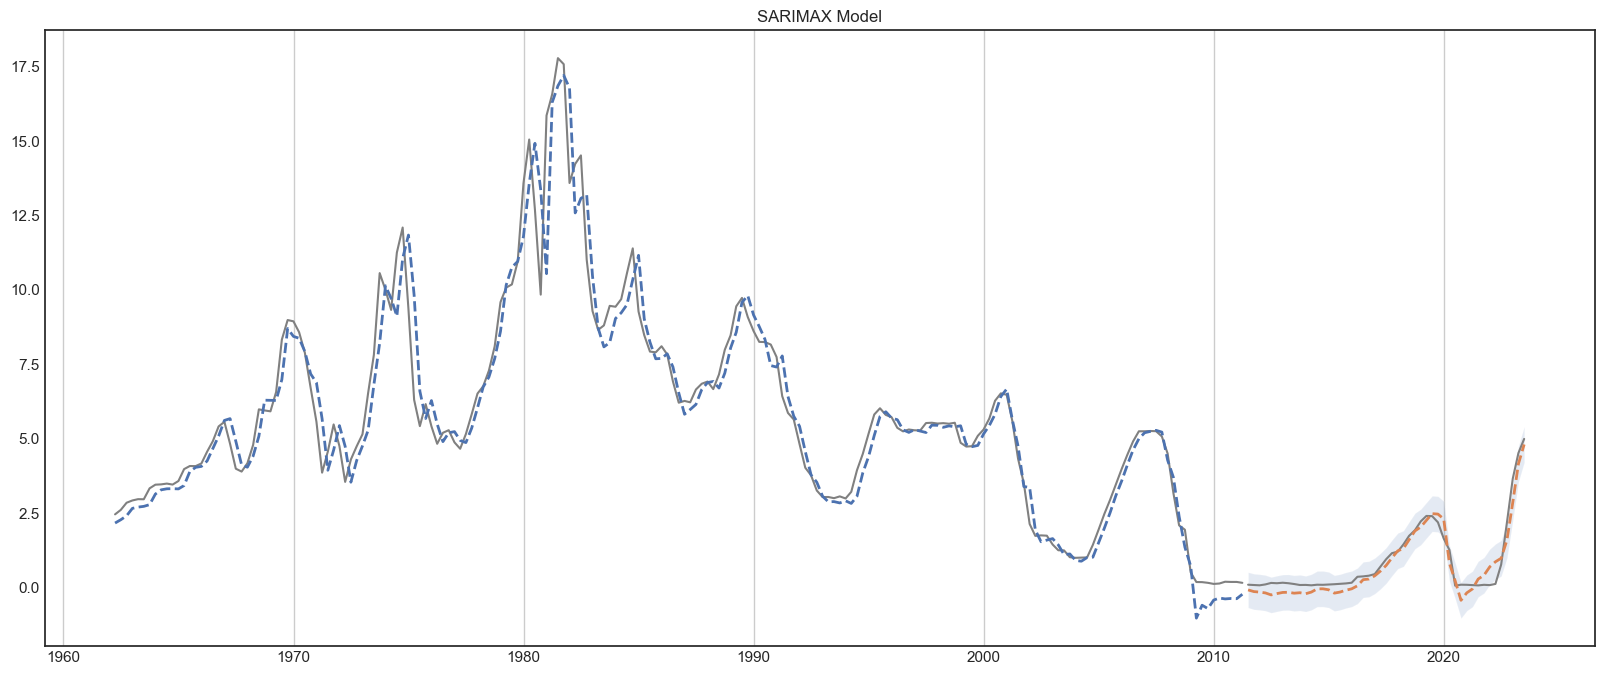

In [78]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'gray')
ax.plot(test_df.index, test_df['FEDFUNDS'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_SARIM.index, predict_ci['lower FEDFUNDS'], predict_ci['upper FEDFUNDS'], alpha=0.15)

ax.set(title='SARIMAX Model');

plt.show()

model_stats_df = model_results('SARIMAX_train',train_df['FEDFUNDS'], train_pred_SARIM['mean'], X_train.shape[0],X_train.shape[1] , model_stats_df )
model_stats_df = model_results('SARIMAX_test', test_df['FEDFUNDS'], test_pred_SARIM['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )
model_stats_df